# База знань про методи виготовлення різьби
Цей інтерактивний документ Jupyter призначений для роботи з базою знань про методи виготовлення різьби. Користувач може переглядати факти бази знань у вигляді таблиці або графа, створювати запити до бази знань, додавати (або видаляти) факти вручну або шляхом застосування механізму логічного виведення.

База знань складається з множини фактів і множини правил логічного виведення. Факти бази знань подані як триплети (суб'єкт, предикат, об'єкт) або (s, p, o). Триплети зберігаються у файлі формату CSV. Для зручного оброблення за допомогою пакету pandas ці триплети завантажуються в таблицю df (DataFrame). Ця таблиця df створюється в модулі mykb.

Віджети IPyWidgets (текстові поля і кнопки) дозволяють інтерактивну роботу з БЗ - пошук триплетів за шаблоном, додавання нових триплетів та їх видалення.

Для візуалізації графа бази знань використовуються пакети NetworkX (створює граф) та Matplotlib (візуалізує граф). NetworkX також можна використати для застосування різноманітних алгоритмів на графах.

Правила і машина виведення описані в модулі example3. Правила логічного виведення (rule1, rule2) дозволяють виводити нові факти за допомогою машини логічного виведення (reasoner). Машина виведення виконує "пряме виведення" та використовує підхід "а-ля RETE" для пришвидшення алгоритму, тобто будує дерево триплетів для швидкого пошуку.

Послідовність запуску через JupyterLite:

1. Відкрийте в браузері https://jupyter.org/try-jupyter/lab/
2. Перетягніть у File Browser (зліва) файли TextSelectInteractKB.ipynb, kb.csv, mykb.py, example3.py
3. Запустіть TextSelectInteractKB.ipynb і виконайте усі комірки

In [1]:
# установлюємо пакети
%pip install -q ipywidgets==8.1.3
%pip install -q pandas

In [2]:
# імпорт пакету для створення віджетів
import ipywidgets, pandas
# імпорт функції для візуалізації результатів
from IPython.display import display, Javascript

<ipython-input-2-24bfb7a20fff>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import ipywidgets, pandas


In [3]:
# з модуля mykb імпортуємо таблицю з фактами бази знань (s, p, o)
import sys
sys.path.append(".")
from mykb import df

In [15]:
# приклад запиту до бази знань:
# вивести таблицю усіх фактів (s, p, o), де s містить "різ" і p містить "перевага"
df[df["s"].str.contains("різ")][df["p"].str.contains("перевага")]

<ipython-input-15-e8856bee58a6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["s"].str.contains("різ")][df["p"].str.contains("перевага")]


,s,p,o
3,нарізання мітчиком,перевага,технологічність
7,нарізання мітчиком,перевага,точність
8,нарізання мітчиком,перевага,придатність для різних матеріалів
9,нарізання мітчиком,перевага,економічність в серійному виробництві


In [5]:
fdf=None # pandas dataframe (таблиця)
import time
# функція виконується під час введення тексту в поля s, p, o
def f1(s, p, o):
    global fdf
    # таблиця fdf містить тільки ті тріплети, які відповідають введениму в поля s, p, o тексту
    fdf=df.loc[df["s"].str.contains(s)].loc[df["p"].str.contains(p)].loc[df["o"].str.contains(o)]
    display(fdf)
    time.sleep(1)

In [6]:
# функція виконується під час натиску на кнопки
def on_button_clicked(b):
    global df
    ndf = pandas.DataFrame([[s.value, p.value, o.value]], columns=['s', 'p', 'o']) # введений тріплет
    # якщо натиснуто "Add to KB"
    if b.description=="Add to KB":
        df=pandas.concat([df, ndf], ignore_index=True)
    # якщо натиснуто "Remove from KB"
    if b.description=="Remove from KB":
        df=pandas.concat([df, ndf], ignore_index=True).drop_duplicates(keep=False, ignore_index=True)
    
    # вивести назву кнопки і тріплет
    #display(Javascript(f"alert('{b.description}: ({s.value}, {p.value}, {o.value})')"))
    with output:
        print(b.description, s.value, p.value, o.value)
        
# створити кнопки і пов'язати їх з on_button_clicked
button1=ipywidgets.Button(description="Add to KB")
button1.on_click(on_button_clicked)
button2=ipywidgets.Button(description="Remove from KB")
button2.on_click(on_button_clicked)
output = ipywidgets.Output()
# кнопки і результати виведення
display(ipywidgets.HBox([button1, button2]), output);

Output()

In [7]:
# створити три текстові поля s, p, o
s=ipywidgets.Text(); p=ipywidgets.Text(); o=ipywidgets.Text()
# повязати їх з f1
ipywidgets.interact(f1, s=s, p=p, o=o);

interactive(children=(Text(value='', description='s'), Text(value='', description='p'), Text(value='', descrip…

In [ ]:
#df = df.drop(index=[4]) # видалити за індексом

In [8]:
# імпорт пакетів networkx і matplotlib
import networkx
import matplotlib.pyplot as plt

In [9]:
# створити орієнтований граф, у якого вершинами є s та o, а дугами - p
G=networkx.DiGraph()
for r in fdf.itertuples(): # для кожного рядка таблиці
    G.add_edges_from([(r.s, r.o)], label=r.p) # створити вершини і дугу

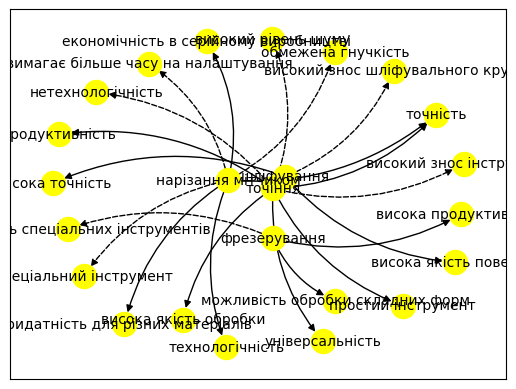

In [16]:
# списки дуг "перевага" та "недолік"
edges_p=[(u,v) for u,v,e in G.edges(data=True) if e['label']=="перевага"]
edges_n=[(u,v) for u,v,e in G.edges(data=True) if e['label']=="недолік"]
pos = networkx.spring_layout(G) # вибрати алгоритм візуалізації графа
# нарисувати вузли, мітки і дуги
networkx.draw_networkx_nodes(G, pos, node_color='yellow')
networkx.draw_networkx_labels(G, pos, font_size=10)
networkx.draw_networkx_edges(G, pos, edgelist=edges_p, connectionstyle='arc3, rad=0.2')
networkx.draw_networkx_edges(G, pos, edgelist=edges_n, style='dashed', connectionstyle='arc3, rad=0.2')
# зберегти граф у форматі SVG
plt.savefig("graph.svg", format="svg")

In [11]:
# імпорт правил і машини логічного виведення з модуля example3
from example3 import *

In [12]:
# наповнити множину F усіма фактами
F=set()
for row in df.itertuples():
    F.add((row.s, row.p, row.o))
# вивести нові факти за правилами rule1, rule2
A=reasoner(F, [rule1, rule2], ["перевага"], ["недолік"])
print(A) # усі факти
print(A-F) # нові факти

{('нарізання мітчиком', 'недолік', 'вимагає більше часу на налаштування'), ('шліфування', 'недолік', 'високий знос шліфувального круга'), ('високий рівень шуму', 'недолік', 'точіння'), ('нарізання мітчиком', 'перевага', 'придатність для різних матеріалів'), ('точіння', 'перевага', 'простий інструмент'), ('точіння', 'перевага', 'продуктивність'), ('нарізання мітчиком', 'перевага', 'технологічність'), ('шліфування', 'перевага', 'висока точність'), ('нетехнологічність', 'недолік', 'точіння'), ('фрезерування', 'перевага', 'можливість обробки складних форм'), ('точіння', 'перевага', 'універсальність'), ('нарізання мітчиком', 'недолік', 'спеціальний інструмент'), ('фрезерування', 'перевага', 'висока продуктивність'), ('точіння', 'недолік', 'нетехнологічність'), ('фрезерування', 'недолік', 'необхідність спеціальних інструментів'), ('спеціальний інструмент', 'недолік', 'нарізання мітчиком'), ('вимагає більше часу на налаштування', 'недолік', 'нарізання мітчиком'), ('точіння', 'недолік', 'висок

In [13]:
df

,s,p,o
0,точіння,перевага,простий інструмент
1,точіння,перевага,точність
2,нарізання мітчиком,недолік,спеціальний інструмент
3,нарізання мітчиком,перевага,технологічність
4,точіння,перевага,продуктивність
5,точіння,перевага,універсальність
6,точіння,недолік,нетехнологічність
7,нарізання мітчиком,перевага,точність
8,нарізання мітчиком,перевага,придатність для різних матеріалів
9,нарізання мітчиком,перевага,економічність в серійному виробництві


In [14]:
df.to_csv('kb.csv', index=False) # зберегти у файл